# Поиск аномалий
- Isolation Forest
- COPOD(Copula-Based Outlier Detection)
- Elliptic Envelope
- One Class SVM 

### Импорт библиотек

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pyod

from sklearn.model_selection import GridSearchCV
from sklearn.svm import OneClassSVM
from catboost import CatBoostClassifier, Pool
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import sklearn.metrics
from sklearn.metrics import RocCurveDisplay, auc, roc_curve, precision_recall_fscore_support,classification_report

import warnings
warnings.filterwarnings('ignore')

### Вспомогательные функции

In [ ]:
def draw_roc_curve(true_labels, predicted_labels):
    fpr, tpr, _ = roc_curve(true_labels, predicted_labels)
    roc_auc = auc(fpr, tpr)
    rcd = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    rcd.plot()
    
def print_classification_report(true_labels, predicted_labels):
    print(classification_report(true_labels, predicted_labels, target_names=['normal','outliers']))
    
def print_confusion_matrix(true_labels, predicted_labels):
    confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()

def print_model_evaluation(true_labels, predicted_labels):
    draw_roc_curve(true_labels, predicted_labels)
    print(classification_report(true_labels, predicted_labels, target_names=['normal','outliers']))
    print_confusion_matrix(true_labels, predicted_labels)
    
def map_preds(data, predicted_labels):
    value_counts = data['Outlier_label'].value_counts()
    normal = value_counts.index[0]
    outlier = value_counts.index[1]
    predicted_labels[predicted_labels==1] = normal
    predicted_labels[predicted_labels==-1] = outlier
    

## EDA

### Датасет и его содержание

Этот набор данных имеет 16 категориальных атрибутов, 5 числовых атрибутов и 1 целевой атрибут, то есть всего 22 атрибута.

1) Описание переменной для категориальных атрибутов:
- возраст: непрерывный.
- пол: категориальный, М, Ж.
- на тироксин: категориальный, ф, т. н.
- запрос на тироксин: категориальный, f, t.
- по антитиреоидным препаратам: категориальный, f, t.
- больной: категориальный, ж, т.
- беременные: категориальный, ж, т.
- хирургия щитовидной железы: категориальный, ж, т.
- I131 лечение: категоричное, f, t.
- запрос гипотиреоз: категориальный, f, t.
- запрос гипертиреоз: категориальный, f, t.
- литий: категориальный, ж, т.
- зоб: категориальный, f, t.
- опухоль: категориальная, f, t.
- гипофизарные: категориальные, f, t.
- псих: категориальный, ж, т.
- Для удобства возраст нормирован на (0,1), все категориальные переменные отображаются следующим образом: {"M" -> 0 , "F" -> 1} или {"f" -> 0, "т" -> 1}.

2) Описание переменной для числовых атрибутов:
ТТГ: непрерывный.
T3: непрерывный.
ТТ4: непрерывный.
T4U: непрерывный.
ФТИ: непрерывный.

3) Описание переменной для целевых атрибутов:
outlierlabel(target): категориальный, o, n. Для целевого атрибута (Outlierlabel) «o» означает выброс, а «n» означает нормальный. 
В конце есть два пустых столбца, их нужно просто удалить

In [ ]:
df = pd.read_csv('sample_data/annthyroid.csv', delimiter=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6916 entries, 0 to 6915
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        6916 non-null   float64
 1   Sex                        6916 non-null   float64
 2   on_thyroxine               6916 non-null   float64
 3   query_on_thyroxine         6916 non-null   float64
 4   on_antithyroid_medication  6916 non-null   float64
 5   sick                       6916 non-null   float64
 6   pregnant                   6916 non-null   float64
 7   thyroid_surgery            6916 non-null   float64
 8   I131_treatment             6916 non-null   float64
 9   query_hypothyroid          6916 non-null   float64
 10  query_hyperthyroid         6916 non-null   float64
 11  lithium                    6916 non-null   float64
 12  goitre                     6916 non-null   float64
 13  tumor                      6916 non-null   float

In [ ]:
df.describe()

,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,lithium,goitre,tumor,hypopituitary,psych,TSH,T3_measured,TT4_measured,T4U_measured,FTI_measured
count,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,...,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000,6916.000000
mean,0.595098,0.307548,0.134615,0.015616,0.013158,0.038317,0.011278,0.014315,0.016773,0.062753,...,0.013013,0.008531,0.025448,0.000145,0.049740,1.603466,11.772446,94.253834,88.270139,95.257058
std,6.189326,0.461512,0.341337,0.123993,0.113959,0.191974,0.105606,0.118793,0.128428,0.242536,...,0.113339,0.091975,0.157494,0.012025,0.217422,14.047218,11.836250,50.555642,33.909845,55.031137
min,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000500,0.002500,0.050000,0.002400
25%,0.370000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000680,0.020100,77.000000,83.000000,81.000000
50%,0.540000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.001700,13.000000,101.000000,96.000000,105.000000
75%,0.670000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002700,22.000000,123.000000,104.000000,125.000000
max,515.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,494.000000,95.000000,395.000000,233.000000,642.000000


In [ ]:
df.head()

,Age,Sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,goitre,tumor,hypopituitary,psych,TSH,T3_measured,TT4_measured,T4U_measured,FTI_measured,Outlier_label
0,0.45,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,61.0,6.0,23.0,87.0,26.0,o
1,0.61,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.0,15.0,61.0,96.0,64.0,o
2,0.16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,29.0,19.0,58.0,103.0,56.0,o
3,0.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,114.0,3.0,24.0,61.0,39.0,o
4,0.75,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,49.0,3.0,5.0,116.0,4.0,o


### Очистка. Маппинг целевой переменной n->0, o->1

In [ ]:
# data = df.drop(columns=['Unnamed: 22','Unnamed: 23'])
data = df
data['Outlier_label'] = data['Outlier_label'].map({'n': 0, 'o': 1})

### Анализ отношений между переменными

#### Матрица корреляций

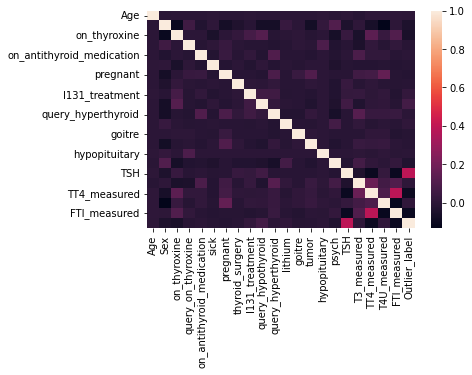

In [ ]:
corr = data.corr()
sns.heatmap(corr)

#### Корреляция переменных с таргетом.

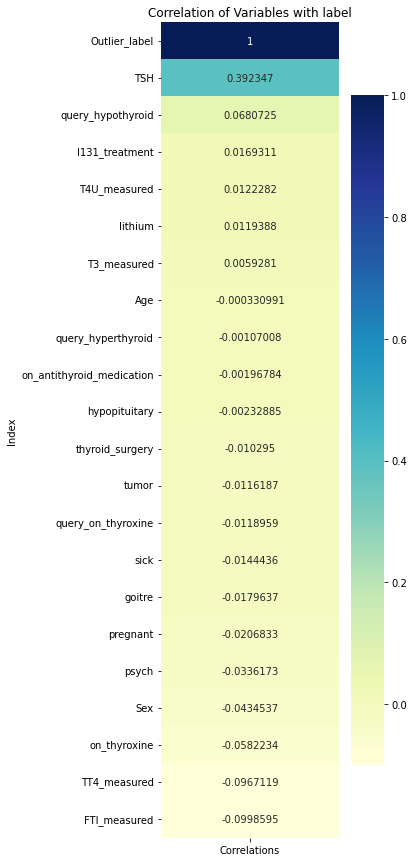

In [ ]:
corr = data.corrwith(data['Outlier_label']).reset_index()
corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False)
plt.figure(figsize=(4,15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='YlGnBu')
plt.title("Correlation of Variables with label")
plt.show()

#### Распределение данных(Метод главных компонент)

In [ ]:
X = data.drop(['Outlier_label'], axis=1)
y = data['Outlier_label']

In [ ]:
x_plot=data.drop(columns=["Outlier_label"])
pca = PCA(n_components=3)
components=pca.fit_transform(X,y)
var = pca.explained_variance_ratio_.sum()*100
fig=px.scatter_3d(
    components,
    x=0,
    y=1,
    z=2,
    color=data['Outlier_label'],
title=f'Total Explained Variance: {var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'})
fig.show()

In [ ]:
x_plot=data.drop(columns=["Outlier_label"])
pca = PCA(n_components=2)
components=pca.fit_transform(X,y)
var = pca.explained_variance_ratio_.sum()*100
fig=px.scatter(
    components,
    x=0,
    y=1,
    color=data['Outlier_label'],
title=f'Total Explained Variance: {var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'})
fig.show()

#### Распределение данных

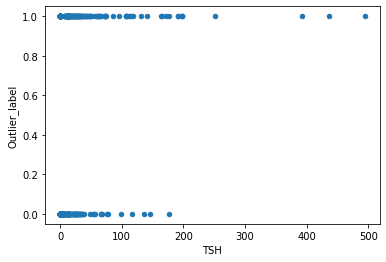

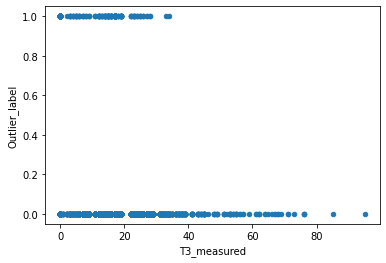

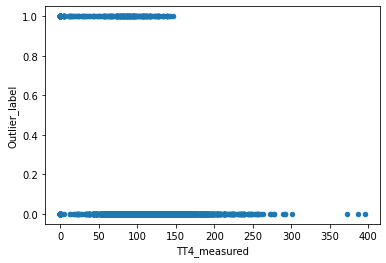

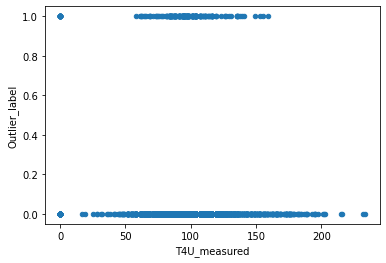

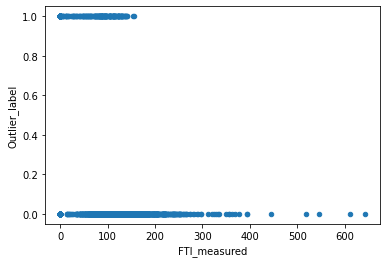

In [ ]:
columns_to_plot = [ 'TSH', 'T3_measured',
       'TT4_measured', 'T4U_measured', 'FTI_measured']
for i in columns_to_plot:
    data.plot(kind='scatter', x=i,y = 'Outlier_label')


## Поиск аномалий

### Isolation Forest

In [ ]:
X_later = data.drop(['Outlier_label'], axis=1)
params = {'n_estimators': list(range(5, 15)), 'max_features': list(range(2, 20))}
oif = GridSearchCV(IsolationForest(n_jobs=2, random_state=5, contamination=float(.03)), params, scoring='homogeneity_score', cv=5)
oif.fit(X_later, y)
preds_oif = oif.predict(X_later)
map_preds(data, preds_oif)
print(oif.best_params_)

{'max_features': 4, 'n_estimators': 9}


              precision    recall  f1-score   support

      normal       0.98      0.98      0.98      6666
    outliers       0.40      0.33      0.36       250

    accuracy                           0.96      6916
   macro avg       0.69      0.66      0.67      6916
weighted avg       0.95      0.96      0.96      6916



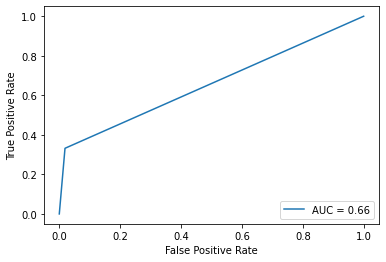

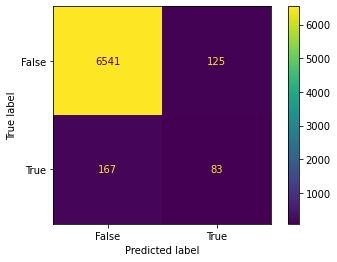

In [ ]:
print_model_evaluation(y, preds_oif)

### One Class SVM

In [ ]:
#params_svm = {'nu':[0.1 ,0.2, 0.3, 0.4,0.5, 0.6,0.7,0.8,0.9,1]            }
#svm = GridSearchCV(OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.005,           max_iter=-1, nu=0.1, shrinking=True, tol=0.001, verbose=False,kernel='rbf'), params_svm, scoring='homogeneity_score', cv=5)
svm = OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.005, max_iter=-1, nu=0.2, shrinking=True, tol=0.001, verbose=False,kernel='rbf')
svm.fit(X_later, y)
preds_svm = svm.predict(X_later)
map_preds(data, preds_svm)
#print(svm.best_params_)

              precision    recall  f1-score   support

      normal       0.98      0.80      0.88      6666
    outliers       0.09      0.54      0.16       250

    accuracy                           0.79      6916
   macro avg       0.54      0.67      0.52      6916
weighted avg       0.95      0.79      0.85      6916



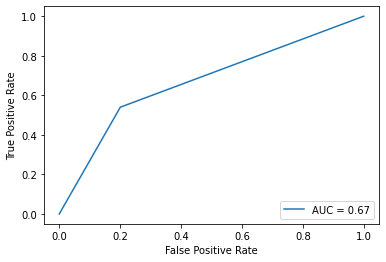

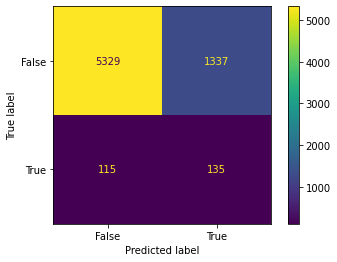

In [ ]:
print_model_evaluation(y, preds_svm)

### CatBoost

In [ ]:
X_train,  X_test, y_train, y_test = train_test_split(X_later,y, random_state=5,test_size=0.7)
pool_train = Pool(X_train, y_train)
cb= CatBoostClassifier(verbose=200)
cb.fit(pool_train)
preds_cb = cb.predict(X_test)

Learning rate set to 0.014067
0:	learn: 0.6510068	total: 49.8ms	remaining: 49.7s
200:	learn: 0.0161284	total: 598ms	remaining: 2.38s
400:	learn: 0.0076340	total: 1.14s	remaining: 1.7s
600:	learn: 0.0047045	total: 1.7s	remaining: 1.13s
800:	learn: 0.0035128	total: 2.19s	remaining: 545ms
999:	learn: 0.0024156	total: 2.68s	remaining: 0us


              precision    recall  f1-score   support

      normal       1.00      0.99      1.00      4658
    outliers       0.87      0.96      0.91       184

    accuracy                           0.99      4842
   macro avg       0.93      0.98      0.95      4842
weighted avg       0.99      0.99      0.99      4842



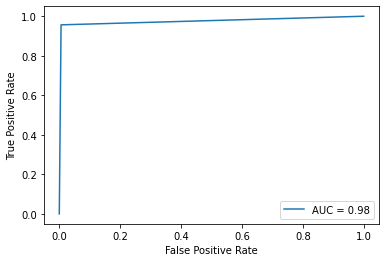

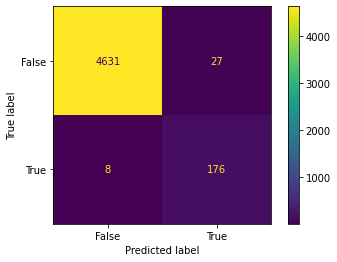

In [ ]:
print_model_evaluation(y_test, preds_cb)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

COPOD ROC:0.6678, PRN: 0.06


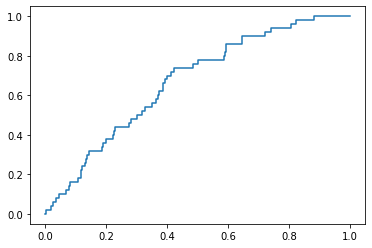

In [ ]:
# with train data
from pyod.models.copod import COPOD
clf_name = 'COPOD'
clf = COPOD()
clf.fit(X_train, y_train)
test_scores = clf.decision_function(X_test)

from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score
roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
prn = round(precision_n_scores(y_test, test_scores), ndigits=4)
print(f'{clf_name} ROC:{roc}, PRN: {prn}')

from sklearn import metrics
import matplotlib.pyplot as plt
fpr, tpr, _ = metrics. roc_curve (y_test, test_scores)

#create ROC curve
plt.plot (fpr,tpr)

plt.show() 

COPOD ROC:0.7026, PRN: 0.12


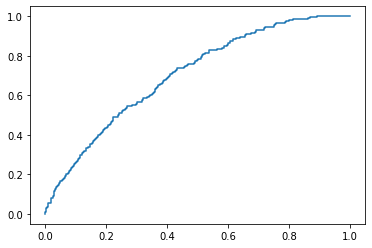

In [ ]:
# without train data
import matplotlib.pyplot as plt

detector = COPOD()
scores = detector.decision_function(X)

roc = round(roc_auc_score(y, scores), ndigits=4)
prn = round(precision_n_scores(y, scores), ndigits=4)
print(f'{clf_name} ROC:{roc}, PRN: {prn}')

fpr, tpr, _ = metrics. roc_curve (y, scores)

#create ROC curve
plt.plot (fpr,tpr)
plt.show() 

In [ ]:
# EllipticEnvelope with train
clf_name = 'EllipticEnvelope'
import numpy as np
from sklearn.covariance import EllipticEnvelope
cov = EllipticEnvelope(random_state=0).fit(X_train, y_train)
predict_results = cov.score(X_test, y_test)
print(f'Score result: {predict_results}')

Score result: 0.02023121387283237


EllipticEnvelope ROC:0.2593, PRN: 0.036


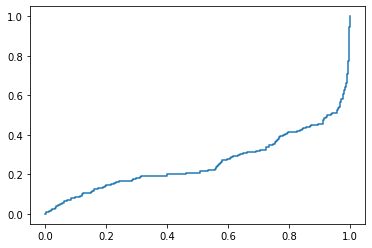

In [ ]:
# EllipticEnvelope without train
test_scores = cov.decision_function(X)

from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score
roc = round(roc_auc_score(y, test_scores), ndigits=4)
prn = round(precision_n_scores(y, test_scores), ndigits=4)
print(f'{clf_name} ROC:{roc}, PRN: {prn}')

fpr, tpr, _ = metrics. roc_curve (y, test_scores)

#create ROC curve
plt.plot (fpr,tpr)
plt.show()